## Week6

In this part, we'll load a pre-trained network and play with it.

In [9]:
from __future__ import print_function
from sys import version_info

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import theano
import theano.tensor as T
import lasagne

try:
    import cPickle as pickle
except ImportError:
    import pickle

%matplotlib inline

from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo (4 pts)
Lasagne has a plethora of pre-training netrworks in the [model zoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo)
* Even more models within the community (neighbor repos, PRs, etc.)


We'll start by picking VGG16 and deploying it in our notebook.

__Warning!__ VGG16 network requires around 3GB of memory to predict event for single-image batch. If you don't have that luxury, try [binder](http://mybinder.org/repo/yandexdataschool/practical_rl) or [azure notebooks](http://notebooks.azure.com/).


In [3]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl -O weights.pkl

--2017-03-24 15:00:52--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 64:ff9b::34d8:143
Connecting to s3.amazonaws.com (s3.amazonaws.com)|64:ff9b::34d8:143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: `weights.pkl'

100%[======================================>] 553 459 517 16,6M/s   in 2m 36s  

2017-03-24 15:03:29 (3,37 MB/s) - `weights.pkl' saved [553459517/553459517]



In [2]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/

from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
#     <paste network architecture here>

    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)
    
    return net

In [3]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', "rb"))
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, our net won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [4]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1] # RGB to BGR
    img = img - MEAN_VALUES.reshape(1, 1, 3)
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img.astype("float32")

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [5]:
net = build_model()

In [6]:
with open('weights.pkl', 'rb') as f:
    if version_info.major == 2:
        weights = pickle.load(f)
    elif version_info.major == 3:
        weights = pickle.load(f, encoding='latin1')

In [7]:
lasagne.layers.set_all_param_values(net["prob"], weights["param values"])

In [35]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net["prob"], input_image, deterministic=True)

prob = theano.function([input_image], output) 

### Sanity check
Let's make sure our network actually works. 

To do so, we'll feed it with some example images.

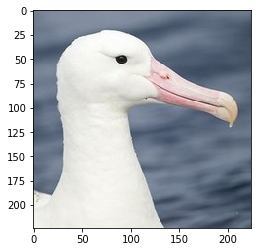

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [18]:
img = imread('albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

##### Ouch!
Try running network 2-3 times. If output changes, then we've probably done something wrong.

Figure out, what's the problem with the network.

_hint_ there are two such 'problematic' layers in vgg16. They're all near the end.

You can make network deterministic by giving it such flag in the `lasagne.layers.get_output` function above.

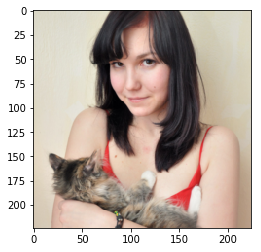

top-5 classes are:
0.240503	tabby
0.148150	Egyptian cat
0.071178	tiger cat
0.054145	cairn
0.042680	tub


In [29]:
img = imresize(imread('avatar.jpeg')[200:1500, :, :], (224, 224, 3))
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

#### Fun opportunity

ImageNet does not contain any human classes, so if you feed the network with some human photo, it will most likely hallucinate something which is closest to your image.

Try feeding the network with something peculiar: your avatar, Donald Trump, Victor Lempitsky or anyone.

# Grand-quest: Dogs Vs Cats (6 pts)
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

Отрежем от сети последний слой, а все остальное оставим.

In [9]:
input_image = T.tensor4('input')
output_fc7 = lasagne.layers.get_output(net['fc7'], input_image, deterministic = True)
fc7 = theano.function([input_image], output_fc7)

In [10]:
from tqdm import tqdm

In [34]:
#extract features from images

X = np.zeros((0, 4096))
Y = []

#this may be a tedious process. If so, store the results in some pickle and re-use them.
images = []
for i, fname in enumerate(os.listdir('train/')):
    y = fname.startswith("cat")
    Y.append(y)
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    images.append(img)
    if (i + 1) % 100 == 0:
        features = fc7(np.concatenate(images))
        X = np.concatenate((X, features))
        images = []

In [27]:
X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]


y = np.array(Y)
print (X.shape, y.shape)

(25000, 4096) (25000,)


На всякий случай сохраним.

In [28]:
np.save("X.npy", X)
np.save("y.npy", y)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [7]:
print("I can do it!")

I can do it!


In [33]:
X_test = np.zeros((0, 4096))
buffer = []
for i, fname in enumerate(sorted(os.listdir('test1/'), key=lambda x:int(x.split(".")[0]))):
    img = imread("test1/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    buffer.append(img)
    if (i + 1) % 100 == 0:
        features = fc7(np.concatenate(buffer))
        X_test = np.concatenate((X_test, features))
        buffer = []

In [61]:
np.save("X_test.npy", X_test)

In [27]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, log_loss
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
clf = RFC(n_estimators = 1000, criterion = "entropy", random_state = 17, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_train[test_index])[:, 1]
clf.score(X_test, y_test)
log_loss(y_train, y_pred)

0.9854
0.0640540168529


In [31]:
y_pred = clf.predict_proba(X_test)[:, 1]

In [34]:
with open("result_rf.txt", "w") as f:
    f.write("id,label\n")
    for i, el in enumerate(y_pred):
        f.write("{},{}\n".format(i + 1, 1 - el))

In [2]:
import lasagne
from lasagne.nonlinearities import *
from lasagne.layers import *
import lasagne.layers.dnn
from lasagne.regularization import regularize_layer_params, l2, l1

input_X = T.matrix("X")
input_shape = [None, 4096]

target_y = T.vector("target Y integer", dtype='int64')

In [21]:
network = lasagne.layers.InputLayer(shape=input_shape, input_var=input_X)
# network = lasagne.layers.DimshuffleLayer(network, (0, 3, 1, 2))
network = lasagne.layers.dnn.Conv2DDNNLayer(network, 32, filter_size=(3, 3), pad='same', nonlinearity=rectify, name="conv1")
# network = lasagne.layers.Conv2DLayer(network, 32, filter_size=(3, 3), pad='same', nonlinearity=rectify, name="conv1")
network = MaxPool2DLayer(network, pool_size=(2, 2), stride=2, name="pool1")
# network = BatchNormLayer(network, name="bn1")
network = lasagne.layers.dropout(network2, p=0.5)

network = batch_norm(lasagne.layers.dnn.Conv2DDNNLayer(network, num_filters=64, filter_size=(2, 2), stride=1, nonlinearity=rectify, name="conv2"))
# network = lasagne.layers.Conv2DLayer(incoming=network, num_filters=64, filter_size=(2, 2), nonlinearity=rectify, name="conv2")
# network2 = lasagne.layers.dropout(network, p=0.2)

network = lasagne.layers.dnn.Conv2DDNNLayer(incoming=network, num_filters=64, filter_size=(3, 3), pad='same', stride=1, nonlinearity=rectify, name="conv2")
# network = lasagne.layers.Conv2DLayer(incoming=network, num_filters=64, filter_size=(2, 2), pad='same', stride=1, nonlinearity=rectify, name="conv2")
network = lasagne.layers.MaxPool2DLayer(incoming=network, pool_size=(2, 2), stride=2, pad=1, name="pool2")
# network = lasagne.layers.BatchNormLayer(incoming=network, name="bn2")

network = DenseLayer(incoming=network, num_units=128, nonlinearity=rectify, name="dense1")
# network = DenseLayer(incoming=network, num_units=100, nonlinearity=rectify, name="dense1")
# network2 = BatchNormLayer(incoming=network2, name="bm_last")

network = DenseLayer(incoming=network, num_units=2, nonlinearity=softmax)

In [22]:
y_predicted = lasagne.layers.get_output(network)
all_weights = lasagne.layers.get_all_params(network, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
loss += lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2) * 2e-3
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adadelta(loss, all_weights)

In [70]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)
predict_fun = theano.function([input_X], [y_predicted], allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)

In [23]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [48]:
from sklearn.cross_validation import train_test_split

X_train = np.load("X.npy")
y_train = np.load("y.npy")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [32]:
batch_size = 128
num_epochs = 100

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train.astype('int32'), batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 100 of 100 took 3.168s (Total: 720.863s)
  training loss (in-iteration): 0.04695956101236136
  train accuracy: 99.99%
  validation accuracy:98.84%


In [75]:
y_pred = predict_fun(np.load("X_test.npy"))
with open("result_nn.txt", "w") as f:
    f.write("id,label\n")
    for i, el in enumerate(y_pred[:, 1]):
        f.write("{},{}\n".format(i + 1, 1 - el))

PS: Хотела добучить resnet, но не успела( качество было бы лучше. а так получается как на rf

PPS: Сори за глупый вопрос, но куда теперь на кагле заливать? не нашла в их новом интерфейсе